# Prediction Of Singapore HDB Prices

## Preparation

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression,ElasticNetCV,\
RidgeCV,LassoCV,Ridge,Lasso,ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, \
cross_val_predict,GridSearchCV,cross_validate
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import warnings
import csv
warnings.filterwarnings('ignore')

### Read Csv into data frame

In [2]:
df = pd.read_csv("../data/train.csv")
df.head(2)

,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,88471,2016-05,KALLANG/WHAMPOA,4 ROOM,3B,UPP BOON KENG RD,10 TO 12,90.0,Model A,2006,...,78,1,1.317659,103.882504,1138.633422,Geylang Methodist School,224,0,1.317659,103.882504
1,122598,2012-07,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,130.0,Improved,1987,...,45,1,1.349783,103.854529,447.894399,Kuo Chuan Presbyterian Secondary School,232,0,1.350110,103.854892


## Data cleaning and feature selection

### Check shape, nulls, zeroes and data type

In [3]:
def check_dataframe_shape_null_zeroes(df):
    print(f"Data frame shape: {df.shape}")
    print("\n")
    nulls = {k:v for k,v in dict(df.isnull().sum()).items() if v>0}
    for k,v in nulls.items():
        print(f"Empty rows in column [{k}]: {v}")
    print("\n")
    zeroes = {k:v for k,v in dict(df[df == 0].count()).items() if v>0}
    for k,v in zeroes.items():
        print(f"Rows with zeroes in column [{k}]: {v}")
    print("\n")

    column_types = {str(k):list(v) for k,v in df.groupby(df.dtypes,axis=1)}
    for k,v in column_types.items():
        print(f"Columns with data type [{k}]:{v}")
        print("\n")
check_dataframe_shape_null_zeroes(df)

Data frame shape: (150634, 77)


Empty rows in column [Mall_Nearest_Distance]: 829
Empty rows in column [Mall_Within_500m]: 92789
Empty rows in column [Mall_Within_1km]: 25426
Empty rows in column [Mall_Within_2km]: 1940
Empty rows in column [Hawker_Within_500m]: 97390
Empty rows in column [Hawker_Within_1km]: 60868
Empty rows in column [Hawker_Within_2km]: 29202


Rows with zeroes in column [1room_sold]: 150552
Rows with zeroes in column [2room_sold]: 144324
Rows with zeroes in column [3room_sold]: 95671
Rows with zeroes in column [4room_sold]: 30379
Rows with zeroes in column [5room_sold]: 62782
Rows with zeroes in column [exec_sold]: 124614
Rows with zeroes in column [multigen_sold]: 150557
Rows with zeroes in column [studio_apartment_sold]: 149226
Rows with zeroes in column [1room_rental]: 150332
Rows with zeroes in column [2room_rental]: 148770
Rows with zeroes in column [3room_rental]: 146805
Rows with zeroes in column [other_room_rental]: 150602
Rows with zeroes in column [Mall_

In [4]:
len(df['full_flat_type'].unique())

43

In [5]:
len(df['flat_model'].unique())

20

In [6]:
df.groupby("flat_type")['flat_model'].value_counts()

flat_type         flat_model            
1 ROOM            Improved                     82
2 ROOM            Model A                     739
                  Standard                    594
                  Improved                    521
                  Premium Apartment            37
                  2-room                        4
                  DBSS                          1
3 ROOM            New Generation            15227
                  Improved                  10240
                  Model A                    8454
                  Standard                   2522
                  Simplified                 1930
                  Premium Apartment           417
                  DBSS                        184
                  Terrace                      86
4 ROOM            Model A                   35127
                  New Generation             8139
                  Premium Apartment          7667
                  Simplified                 5309
         

### Feature Engineering

In [7]:
df['hdb_age_at_tranc'] = df['Tranc_Year']-df['lease_commence_date']

### Imputation of null values

In [8]:
col = ['Hawker_Within_2km','Mall_Within_2km', 'Mall_Nearest_Distance' ]
for i in col:
    mean = np.mean(df[i])
    df[i].fillna(value=mean, inplace=True)

### Manual splitting into categories and numerical features

In [9]:
numerical_columns = []
categorical_columns = []
filename = "../data/data_dictionary_analysis.csv"
data_dict = pd.read_csv(filename)
with open(filename,'r') as data:
    reader = csv.reader(data)
    next(reader, None)  # skip the headers
    for line in reader:
        if line[3]=='1' and line[4] == 'numerical':
            numerical_columns.append(line[1])
        if line[3]=='1' and line[4] == 'Categorical':
            categorical_columns.append(line[1])

pd.set_option('display.max_colwidth', None)
data_dict = data_dict.loc[data_dict['X']==1][['Feature','Description','Data type']]
data_dict

,Feature,Description,Data type
3,flat_type,"type of the resale flat unit, e.g. 3 ROOM",Categorical
7,floor_area_sqm,floor area of the resale flat unit in square metres,numerical
8,flat_model,"HDB model of the resale flat, e.g. Multi Generation",Categorical
10,Tranc_Year,year of resale transaction,Categorical
15,mid,middle value of storey_range,numerical
20,max_floor_lvl,highest floor of the resale flat,numerical
43,planning_area,Government planning area that the flat is located,Categorical
54,mrt_nearest_distance,distance (in metres) to the nearest MRT station,numerical
76,hdb_age_at_tranc,hdb age during the transaction date,numerical


### Check data types

In [10]:
for i in numerical_columns:
    print(f"Column [{i}] has data type [{df[i].dtype}]")
    
for i in categorical_columns:
    print(f"Column [{i}] has data type [{df[i].dtype}] has unique counts [{len(set(df[i]))}]")

Column [floor_area_sqm] has data type [float64]
Column [mid] has data type [int64]
Column [max_floor_lvl] has data type [int64]
Column [mrt_nearest_distance] has data type [float64]
Column [hdb_age_at_tranc] has data type [int64]
Column [flat_type] has data type [object] has unique counts [7]
Column [flat_model] has data type [object] has unique counts [20]
Column [Tranc_Year] has data type [int64] has unique counts [10]
Column [planning_area] has data type [object] has unique counts [32]


## EDA

### Correlation heat map of numerical columns

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0.5, 0, 'floor_area_sqm'),
  Text(1.5, 0, 'mid'),
  Text(2.5, 0, 'max_floor_lvl'),
  Text(3.5, 0, 'mrt_nearest_distance'),
  Text(4.5, 0, 'hdb_age_at_tranc'),
  Text(5.5, 0, 'resale_price')])

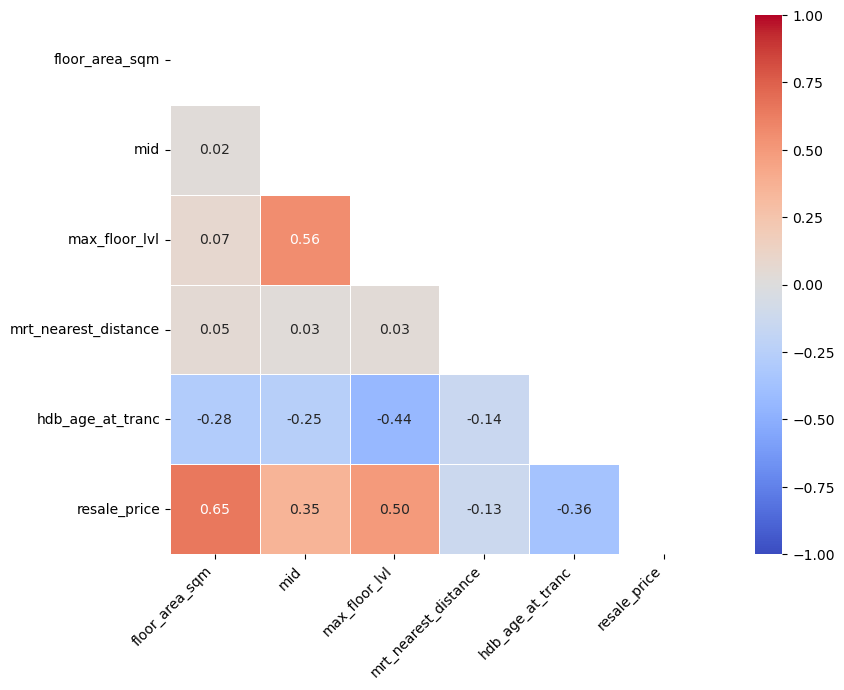

In [11]:
# Use Seaborn's heatmap with pandas .corr() to visualize correlations between all numeric features.
corr = df[numerical_columns+['resale_price']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (12,7))
sns.heatmap(corr, mask = mask, square = True, annot = True, vmin = -1, vmax = 1, linewidths = .5, cmap = "coolwarm",fmt='.2f')
plt.xticks(rotation=45, ha='right') 

### Bar charts for categorical features

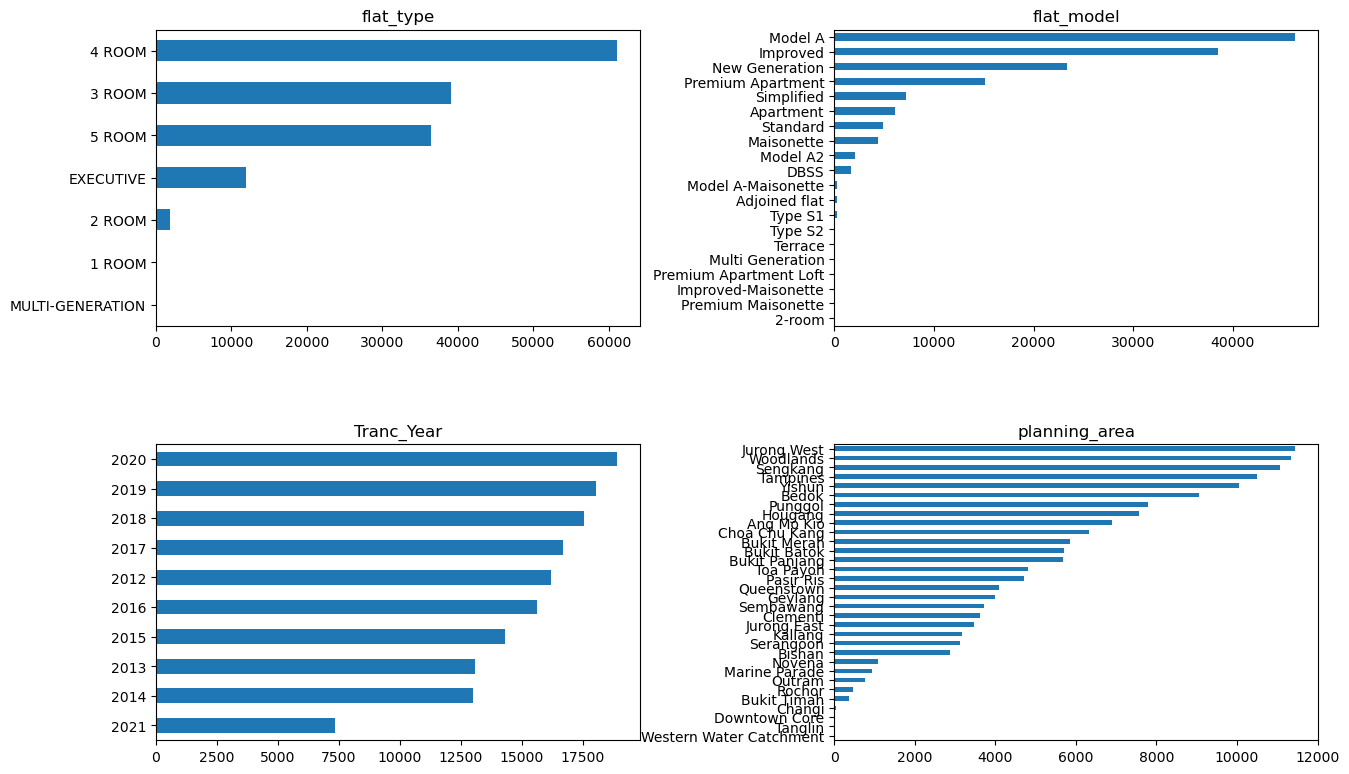

In [12]:
fig1 = plt.figure(figsize=(15,20))
fig1.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(categorical_columns):
    fig1.add_subplot(4,2,idx+1)
    df[d].value_counts().sort_values().plot(kind='barh')
    plt.title(d)

### Histogram for numerical features

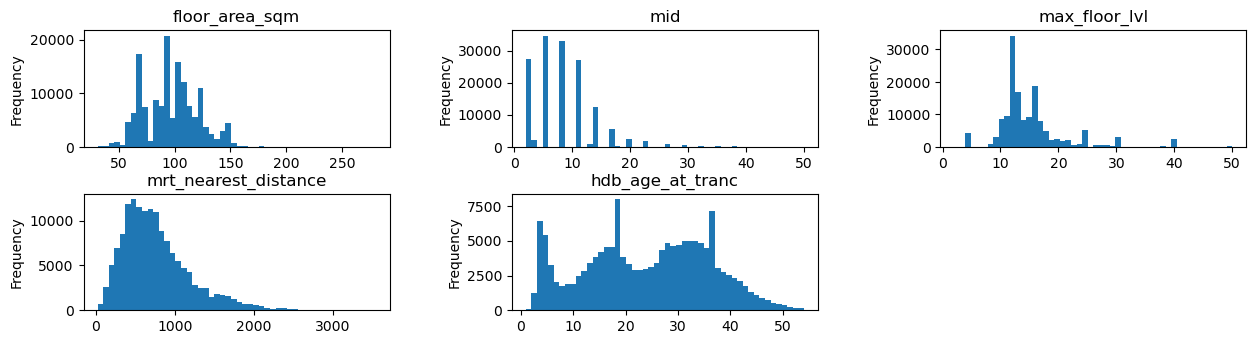

In [13]:
fig1b = plt.figure(figsize=(15,10))
fig1b.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(numerical_columns):
    fig1b.add_subplot(5,3,idx+1)
    df[d].plot(kind='hist',bins=50,title=d)

### Box plots for outliers

In [14]:
def get_outliers_count (column):
    Q1 = np.percentile(column, 25)
    Q3 = np.percentile(column, 75)
    IQR = Q3 - Q1
    return sum((column<(Q1 - 1.5 * IQR)) | (column>(Q3 + 1.5 * IQR)))

outliers = df.groupby('full_flat_type')['resale_price'].agg([get_outliers_count]).sort_values(by=['get_outliers_count'], ascending=False)
outliers[:10]

,get_outliers_count
full_flat_type,
4 ROOM Model A,3640
5 ROOM Improved,1748
3 ROOM Model A,656
3 ROOM New Generation,206
4 ROOM Premium Apartment,163
4 ROOM Simplified,155
3 ROOM Improved,140
EXECUTIVE Maisonette,130
5 ROOM Premium Apartment,128


In [15]:
top = list(outliers[:10].index)
top

['4 ROOM Model A',
 '5 ROOM Improved',
 '3 ROOM Model A',
 '3 ROOM New Generation',
 '4 ROOM Premium Apartment',
 '4 ROOM Simplified',
 '3 ROOM Improved',
 'EXECUTIVE Maisonette',
 '5 ROOM Premium Apartment',
 '3 ROOM Standard']

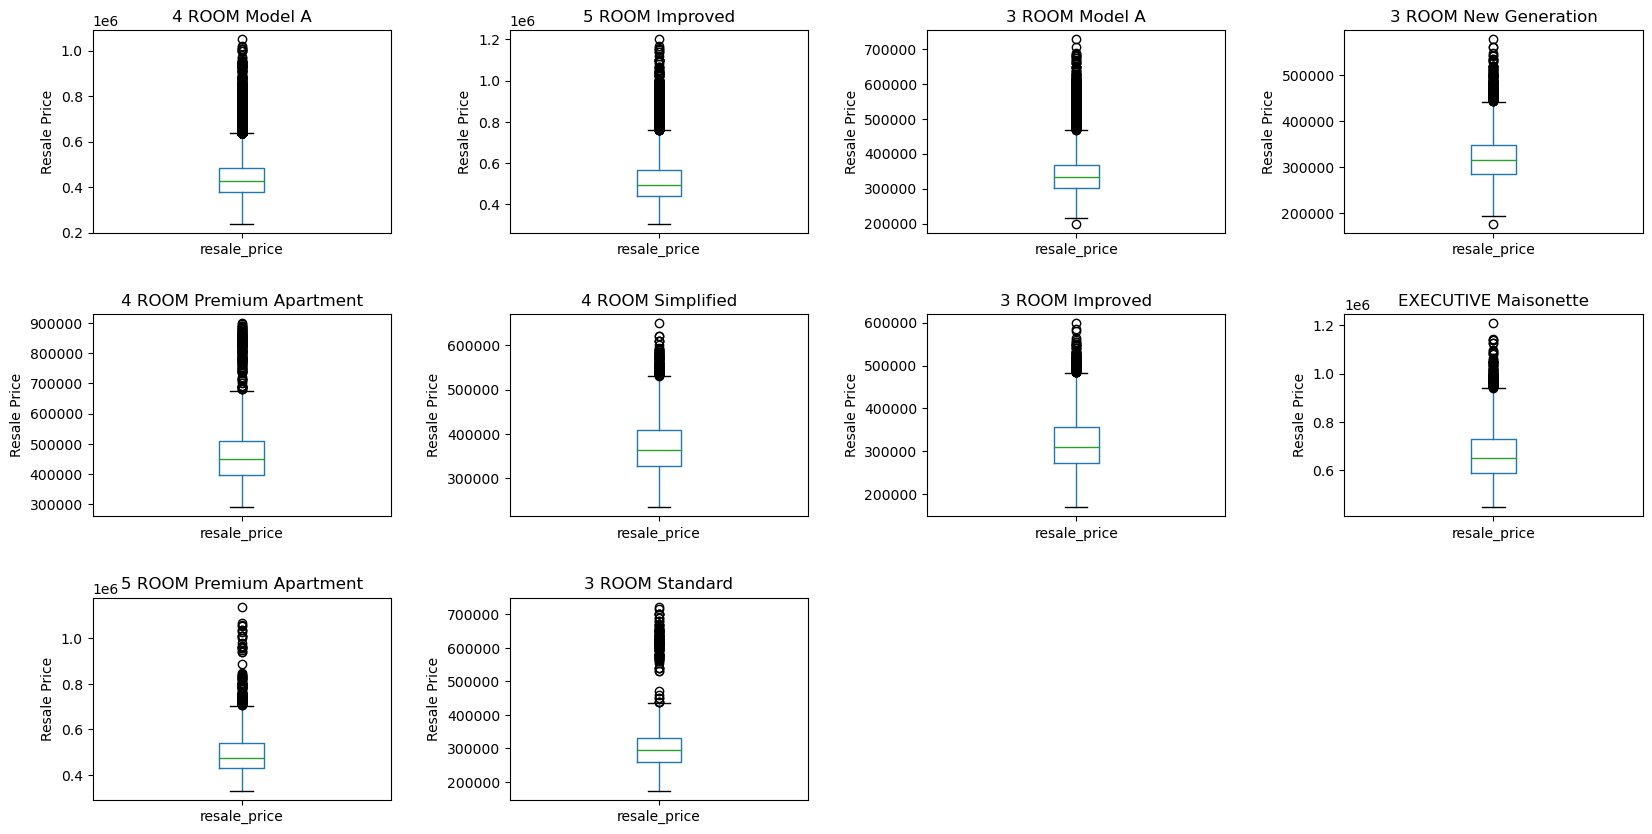

In [16]:
# Plot and interpret boxplots
fig2 = plt.figure(figsize=(20,10))
fig2.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(top):
    fig2.add_subplot(3,4,idx+1)
    bp = df.loc[df['full_flat_type']==d].boxplot(column='resale_price', grid=False)
    plt.ylabel('Resale Price')
    plt.title(d)

In [17]:
len(df.loc[df['full_flat_type'].isin(top)])

120269

In [18]:
len(df.loc[~df['full_flat_type'].isin(top)])

30365

In [19]:
cols = 'resale_price'
Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

df_1 = df.loc[(df['full_flat_type'].isin(top))&(df[cols] > (Q1 - 1.5 * IQR) )& (df[cols] < (Q3 + 1.5 * IQR))]
df_2 = df.loc[~df['full_flat_type'].isin(top)]

print(f"Before filter outliers : {df.shape}")
df = pd.concat([df_1, df_2], ignore_index=True)
print(f"After filter outliers : {df.shape}")

Before filter outliers : (150634, 78)
After filter outliers : (147635, 78)


In [20]:
outliers = df.groupby('full_flat_type')['resale_price'].agg([get_outliers_count]).sort_values(by=['get_outliers_count'], ascending=False)
outliers[:3]

,get_outliers_count
full_flat_type,
4 ROOM Model A,3267
5 ROOM Improved,787
3 ROOM Model A,656


### Scatter plots by Flat types

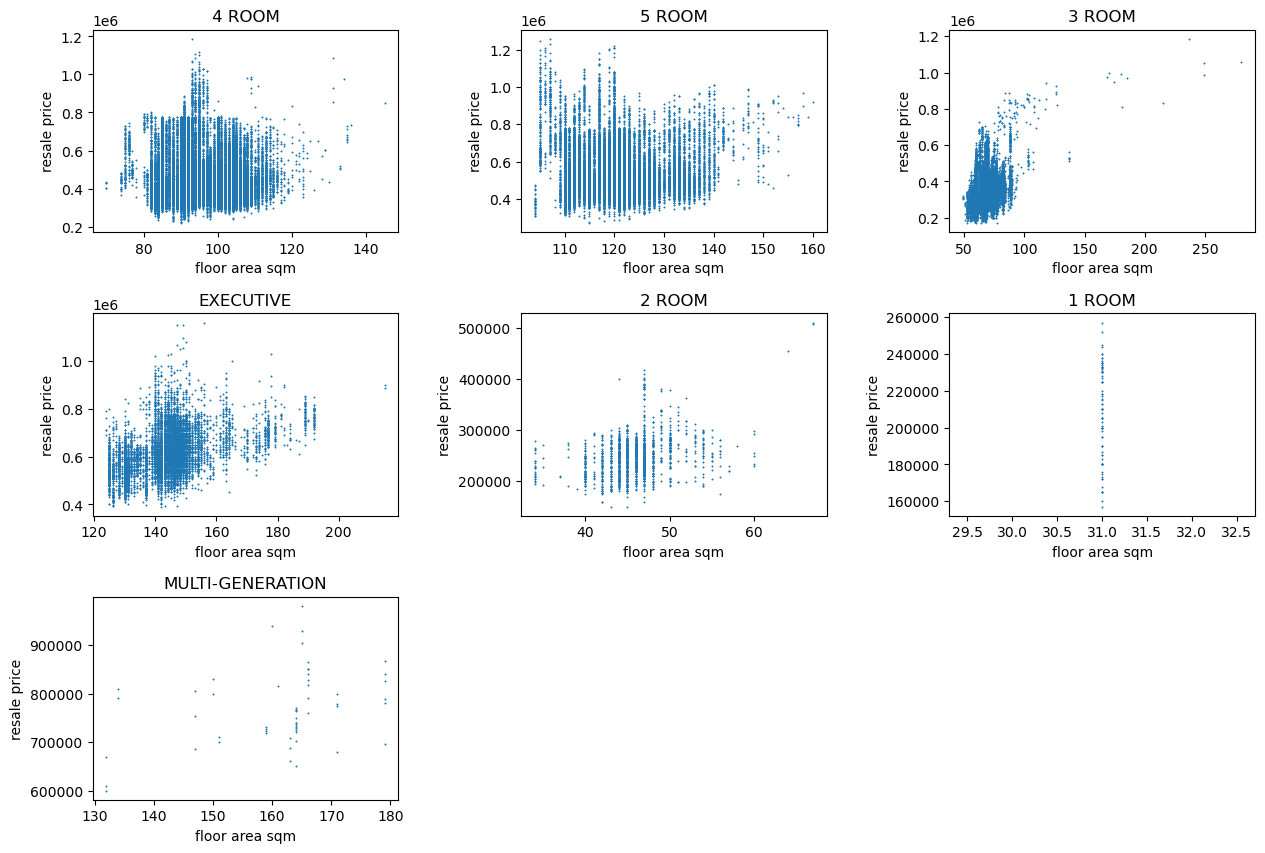

In [21]:
fig3 = plt.figure(figsize=(15,10))
fig3.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(df['flat_type'].unique()):
    x = df.loc[df['flat_type']==d]['floor_area_sqm']
    y = df.loc[df['flat_type']==d]['resale_price']
    fig3.add_subplot(3,3,idx+1)
    plt.scatter(x,y, marker='*',s=0.1)
    plt.xlabel('floor area sqm')
    plt.ylabel('resale price')
    plt.title(d)

### Scatter plots by Planning area

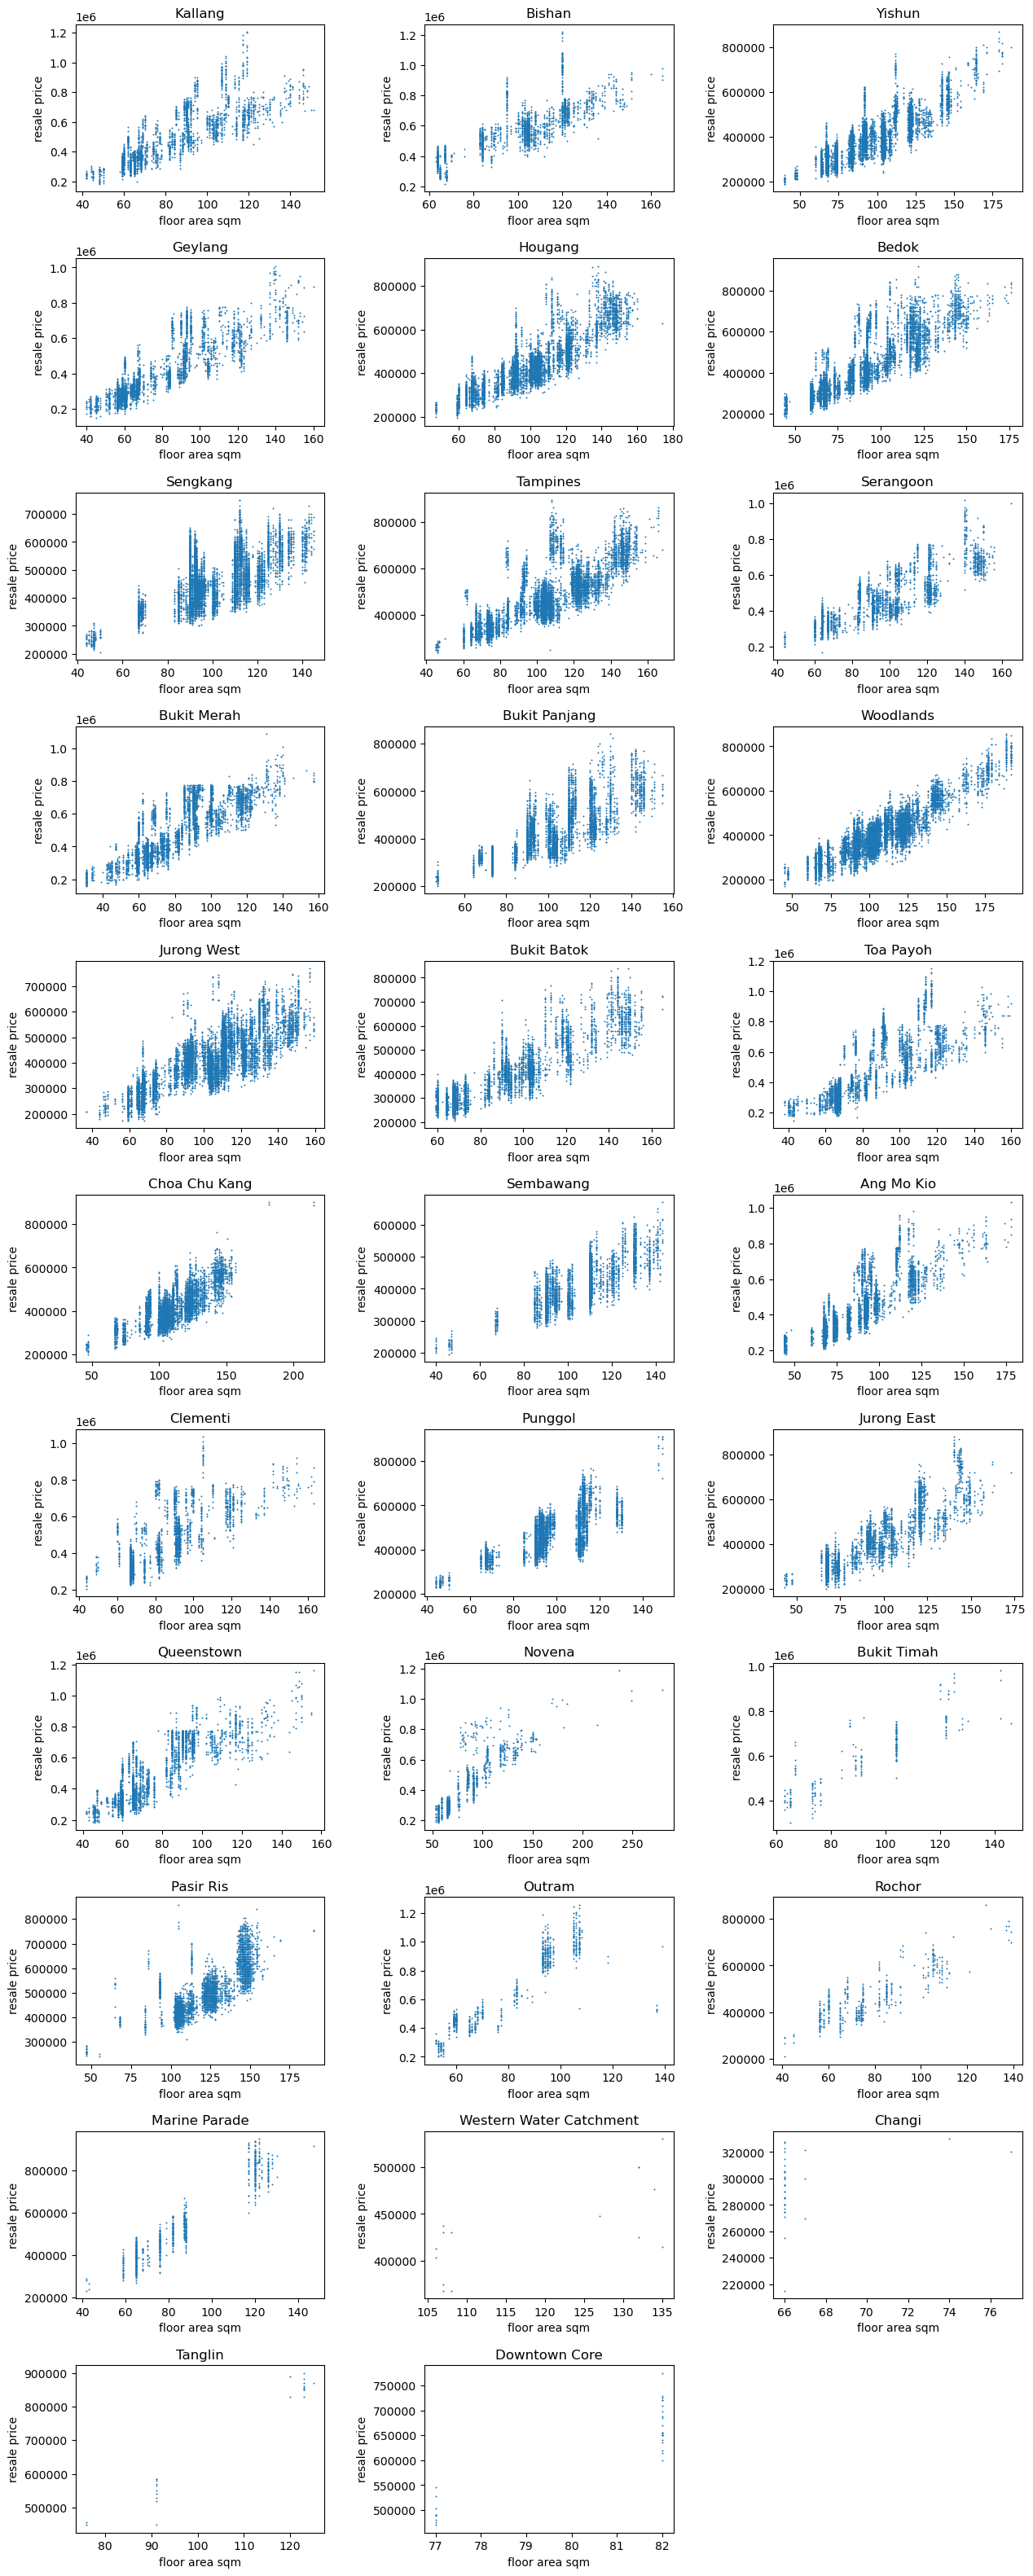

In [22]:
fig4 = plt.figure(figsize=(15,40))
fig4.subplots_adjust(hspace=0.4,wspace=0.4)

indicator = 'planning_area'
for idx, d in enumerate(df[indicator].unique()):
    x = df.loc[(df[indicator]==d)]['floor_area_sqm']
    y = df.loc[(df[indicator]==d)]['resale_price']
    fig4.add_subplot(11,3,idx+1)
    plt.scatter(x,y, marker='*',s=0.1)
    plt.xlabel('floor area sqm')
    plt.ylabel('resale price')
    plt.title(d)

## Feature Engineering and Selection

### Setup features and target. 
#### Use logarithm value of predicted value

In [23]:
X= df[numerical_columns+categorical_columns]
y= df['resale_price']

nulls = {k:v for k,v in dict(X.isnull().sum()).items() if v>0}
for k,v in nulls.items():
    print(f"Empty rows in column [{k}]: {v}")

### Train and Test Split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

## Model Building

In [25]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

In [26]:
%%time
model = Ridge()
pipe = make_pipeline(preprocessor, model)
hyperparameters = {'ridge__alpha': [0.001, 0.01, 0.1,1,10,100]}
gs = GridSearchCV(pipe, hyperparameters,cv=5,scoring='neg_root_mean_squared_error')
gs.fit(X_train,y_train)
print(f"Best Score: {-gs.best_score_}")
print(f"Best Params: {gs.best_params_}")

Best Score: 45575.75890932804
Best Params: {'ridge__alpha': 0.001}
CPU times: total: 32 s
Wall time: 14 s


In [27]:
results = pd.DataFrame(gs.cv_results_)
results.sort_values(['mean_test_score'],ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.405355,0.011042,0.057507,0.004468,0.001,{'ridge__alpha': 0.001},-46009.115791,-45377.130947,-45257.636803,-45718.441274,-45516.469732,-45575.758909,265.452969,1
3,0.413791,0.042957,0.058521,0.006022,1,{'ridge__alpha': 1},-46001.961981,-45379.302580,-45256.027560,-45744.984425,-45517.148037,-45579.884917,266.255394,2
1,0.394159,0.012559,0.054346,0.005277,0.01,{'ridge__alpha': 0.01},-46009.022136,-45376.828117,-45257.497201,-45741.679916,-45515.327542,-45580.070982,268.205056,3
2,0.396580,0.016233,0.060465,0.006655,0.1,{'ridge__alpha': 0.1},-46008.802260,-45377.634030,-45257.242848,-45741.963015,-45516.684696,-45580.465370,268.043021,4
4,0.383736,0.028635,0.056970,0.006879,10,{'ridge__alpha': 10},-46008.451442,-45446.612971,-45281.193416,-45818.138827,-45593.462219,-45629.571775,258.941167,5
5,0.349224,0.030583,0.055834,0.007306,100,{'ridge__alpha': 100},-46576.559132,-46146.180510,-46037.323196,-46842.066166,-46508.042567,-46422.034314,293.870740,6


## Model Evaluation

In [28]:
predicted = gs.best_estimator_.predict(X_test)
mse = metrics.mean_squared_error(y_test, predicted)
print(f"Test score = {np.sqrt(mse):.3f}")
print("The mean cross-validation rmse is: "
      f"{-results['mean_test_score'].mean():.0f} ± {results['std_test_score'].mean():.0f}")

Test score = 45535.145
The mean cross-validation rmse is: 45728 ± 270


In [29]:
def get_coeffs_from_gs(gs):
    coefficients = gs.best_estimator_[1].coef_
    out_columns_numerical = gs.best_estimator_[0].transformers_[1][2]
    out_columns_category = list(gs.best_estimator_[0].transformers_[0][1].get_feature_names())
    out_columns = out_columns_category+out_columns_numerical
    gs_coef = sorted(list(zip(np.round(coefficients,3),out_columns)),key=lambda x: x[0],reverse=True)
    return gs_coef

In [30]:
coefs = get_coeffs_from_gs(gs)
print("Flat Type")
print(*[x for x in coefs if "x0" in x[1]],sep='\n')
print("Flat Model")
print(*[x for x in coefs if "x1" in x[1]],sep='\n')
print("Transaction Year")
print(*[x for x in coefs if "x2" in x[1]],sep='\n')
print("Planning Area")
print(*[x for x in coefs if "x3" in x[1]],sep='\n')
print("Numerical Features")
print(*[x for x in coefs if not x[1].startswith('x')],sep='\n')

Flat Type
(36464.715, 'x0_MULTI-GENERATION')
(24579.3, 'x0_EXECUTIVE')
(13370.805, 'x0_5 ROOM')
(2065.546, 'x0_4 ROOM')
(-12207.081, 'x0_3 ROOM')
(-21961.224, 'x0_1 ROOM')
(-42312.061, 'x0_2 ROOM')
Flat Model
(356918.782, 'x1_Terrace')
(104127.98, 'x1_Type S2')
(44320.514, 'x1_Premium Apartment Loft')
(42495.954, 'x1_DBSS')
(36464.715, 'x1_Multi Generation')
(34586.654, 'x1_Improved-Maisonette')
(30025.627, 'x1_Model A-Maisonette')
(23571.474, 'x1_Type S1')
(7669.853, 'x1_Premium Maisonette')
(-2272.806, 'x1_Adjoined flat')
(-2434.715, 'x1_2-room')
(-38711.792, 'x1_Maisonette')
(-53649.703, 'x1_Apartment')
(-70868.015, 'x1_Standard')
(-77973.184, 'x1_New Generation')
(-79726.707, 'x1_Simplified')
(-82653.313, 'x1_Premium Apartment')
(-89006.096, 'x1_Model A')
(-89710.972, 'x1_Model A2')
(-93174.253, 'x1_Improved')
Transaction Year
(30504.375, 'x2_2013')
(26049.778, 'x2_2021')
(14241.018, 'x2_2012')
(3680.754, 'x2_2014')
(-4155.866, 'x2_2020')
(-11109.367, 'x2_2016')
(-12046.709, 'x2_20

## Prediction

In [31]:
test_df = pd.read_csv("../data/test.csv")
test_df.head(2)

,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,114982,2012-11,YISHUN,4 ROOM,173,YISHUN AVE 7,07 TO 09,84.0,Simplified,1987,...,92,0,1.433681,103.832924,156.322353,Ahmad Ibrahim Secondary School,218,0,1.436235,103.829987
1,95653,2019-08,JURONG WEST,5 ROOM,986C,JURONG WEST ST 93,04 TO 06,112.0,Premium Apartment,2008,...,45,0,1.339244,103.698896,739.371688,Jurong West Secondary School,199,0,1.335256,103.702098


In [32]:
check_dataframe_shape_null_zeroes(test_df)

Data frame shape: (16737, 76)


Empty rows in column [Mall_Nearest_Distance]: 84
Empty rows in column [Mall_Within_500m]: 10292
Empty rows in column [Mall_Within_1km]: 2786
Empty rows in column [Mall_Within_2km]: 213
Empty rows in column [Hawker_Within_500m]: 10755
Empty rows in column [Hawker_Within_1km]: 6729
Empty rows in column [Hawker_Within_2km]: 3254


Rows with zeroes in column [1room_sold]: 16730
Rows with zeroes in column [2room_sold]: 16027
Rows with zeroes in column [3room_sold]: 10607
Rows with zeroes in column [4room_sold]: 3297
Rows with zeroes in column [5room_sold]: 7002
Rows with zeroes in column [exec_sold]: 13916
Rows with zeroes in column [multigen_sold]: 16727
Rows with zeroes in column [studio_apartment_sold]: 16592
Rows with zeroes in column [1room_rental]: 16711
Rows with zeroes in column [2room_rental]: 16516
Rows with zeroes in column [3room_rental]: 16319
Rows with zeroes in column [other_room_rental]: 16736
Rows with zeroes in column [Mall_Nearest_Distance]

In [33]:
test_df['hdb_age_at_tranc'] = test_df['Tranc_Year']-test_df['lease_commence_date']

In [34]:
col = ['Hawker_Within_2km','Mall_Within_2km', 'Mall_Nearest_Distance' ]
for i in col:
    mean = np.mean(test_df[i])
    test_df[i].fillna(value=mean, inplace=True)

In [35]:
X_test_df = test_df[numerical_columns+categorical_columns]

In [36]:
pred = gs.best_estimator_.predict(X_test_df)
pred.shape

(16737,)

In [37]:
sub_df = pd.DataFrame()
sub_df["Id"] = test_df['id'] 
sub_df["Predicted"] = pred
sub_df.to_csv("../data/sub_reg.csv", index=False)

In [38]:
sub_df.head()

,Id,Predicted
0,114982,382177.345805
1,95653,501286.869102
2,40303,384638.511908
3,109506,261724.733988
4,100149,450952.634218


In [39]:
sub_df.shape

(16737, 2)